In [1]:
# import necessary stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import time
import pickle
import pprint
import chardet
from telegram import Bot
from multiprocessing import Pool, cpu_count
from struct import pack

In [2]:
# initialize pretty printer
pp = pprint.PrettyPrinter(indent=4, depth=8)

In [3]:
# initilize telegram bot
token = "350553078:AAEu70JDqMFcG_x5eBD3nqccTvc4aFNMKkg"
chat_id = "126551968"
bot = Bot(token)

In [4]:
EXPORT_AS_EDGE_LIST = True

In [5]:
# define dataset file paths
dataset_path = 'data/BlogCatalog-dataset/data/'
friend_edges_csv_path = dataset_path + 'edges.csv'
group_edges_csv_path = dataset_path + 'group-edges.csv'
groups_csv_path = dataset_path + 'groups.csv'
bloggers_csv_path = dataset_path + 'nodes.csv'

In [6]:
# store cvs contents in dataframe
friend_edges_df = pd.read_csv(friend_edges_csv_path, sep=',', header=None, dtype={0: str, 1:str})
group_edges_df = pd.read_csv(group_edges_csv_path, sep=',', header=None, dtype={0: str, 1:str})
groups_df = pd.read_csv(groups_csv_path, sep=',', header=None, dtype={0: str})
bloggers_df = pd.read_csv(bloggers_csv_path, sep=',', header=None, dtype={0: str})

In [7]:
# give bloggers and groups unique node-ids
bloggers_df[0] = 'b' + bloggers_df[0]
friend_edges_df = 'b' + friend_edges_df
groups_df[0] = 'g' + groups_df[0]
group_edges_df[0] = 'b' + group_edges_df[0]
group_edges_df[1] = 'g' + group_edges_df[1]

In [8]:
# define networkx graph
blog_catalog_graph = nx.Graph()

In [9]:
# define node and edge label constants
IS_MEMBER_OF = 'is_member_of'
IS_FRIEND_WITH = 'is_friend_with'
BLOGGER = 'blogger'
GROUP = 'group'

In [10]:
# add blogger and group nodes to graph
blog_catalog_graph.add_nodes_from(bloggers_df[0].tolist(), label=BLOGGER)
print("{} nodes in graph".format(blog_catalog_graph.number_of_nodes()))
blog_catalog_graph.add_nodes_from(groups_df[0].tolist(), label=GROUP)
print("{} nodes in graph".format(blog_catalog_graph.number_of_nodes()))

10312 nodes in graph
10351 nodes in graph


In [11]:
# create edge tuples from dataframe
group_edges = list(zip(group_edges_df[0].tolist(), group_edges_df[1].tolist()))
friend_edges = list(zip(friend_edges_df[0].tolist(), friend_edges_df[1].tolist()))

In [12]:
# add (blogger)-[is_member_of]-(group) edges to graph
blog_catalog_graph.add_edges_from(group_edges, label=IS_MEMBER_OF)
print("{} edges in graph".format(blog_catalog_graph.number_of_edges()))
print("{} nodes in graph".format(blog_catalog_graph.number_of_nodes()))

14476 edges in graph
10351 nodes in graph


In [13]:
# add (blogger)-[is_friend_with]-(blogger) edges to graph
blog_catalog_graph.add_edges_from(friend_edges, label=IS_FRIEND_WITH)
print("{} edges in graph".format(blog_catalog_graph.number_of_edges()))
print("{} nodes in graph".format(blog_catalog_graph.number_of_nodes()))

348459 edges in graph
10351 nodes in graph


In [14]:
# export graph as edge list to given path
if EXPORT_AS_EDGE_LIST:
    edge_list_export_path = dataset_path + 'blogcatalog_edgelist.csv'
    nx.write_edgelist(blog_catalog_graph, edge_list_export_path, data=False)

In [15]:
# compute average degree of all nodes in graph
node_degrees = np.array(list(dict(blog_catalog_graph.degree(list(blog_catalog_graph.nodes))).values()),dtype=np.int64)
avg_node_degree = np.mean(node_degrees)
print("The avg. node degree is {}".format(np.round(avg_node_degree, decimals=2)))

The avg. node degree is 67.33


In [16]:
# define random walk parameters
sim_G_sampling = {}
samples_per_node = 10
finished_nodes = 0
experiment_name = 'Blog-Catalog Node Sampling V1'

In [17]:
# define meta-path scoring information
meta_path_scheme_A = [GROUP, IS_MEMBER_OF, BLOGGER, IS_MEMBER_OF, GROUP]
meta_path_scheme_B = [BLOGGER, IS_MEMBER_OF, GROUP, IS_MEMBER_OF, BLOGGER, IS_MEMBER_OF, GROUP]
meta_path_schemes = {BLOGGER: [meta_path_scheme_B], GROUP: [meta_path_scheme_A]}
scoring_function = {}

In [18]:
# sample a meta-path scheme from all meta-path schemes according to given scoring function
def sample_meta_path_scheme(node):
    node_label = blog_catalog_graph.nodes[node]['label']
    meta_path_scheme_index = np.random.choice(list(range(len(meta_path_schemes[node_label]))))
    meta_path_scheme = meta_path_schemes[node_label][meta_path_scheme_index]
    
    return meta_path_scheme

In [19]:
# check, wheter neighbor (candidate) of node i in walk fulfills requirements given through meta-path scheme
def candidate_valid(node, candidate, meta_path_scheme,step):
    node_label_valid = blog_catalog_graph.nodes[candidate]['label'] == meta_path_scheme[step*2]
    edge_label_valid = blog_catalog_graph[node][candidate]['label'] == meta_path_scheme[step*2-1]
    
    return node_label_valid and edge_label_valid

In [20]:
# compute transition probabilities for all neighborhood nodes of node i according to given meta-path
def compute_transition_probabilities(meta_path_scheme, step, node):
    candidate_set = [n for n in blog_catalog_graph.neighbors(node)]
    transition_probabilities = np.ones(len(candidate_set), dtype=np.float64)
    
    for i, candidate in enumerate(candidate_set):
        if not candidate_valid(node, candidate, meta_path_scheme, step):
            transition_probabilities[i] = 0
            
    transition_probabilities = transition_probabilities / np.sum(transition_probabilities)
    
    return transition_probabilities
            

In [21]:
# run single random walk with transistion probabilities accoring to scoring function
def run_single_random_walk(start_node):
    visited_nodes = []
    current_node = start_node
    meta_path_scheme = sample_meta_path_scheme(start_node)
    walk_length = int((len(meta_path_scheme) - 1) / 2)
    
    for i in range(1,walk_length+1):
        visited_nodes.append(current_node)
        transition_probabilities = compute_transition_probabilities(meta_path_scheme, i, current_node)
        
        if np.sum(transition_probabilities) == 0:
            return visited_nodes
        current_node = np.random.choice([n for n in blog_catalog_graph.neighbors(current_node)], p=transition_probabilities)
    
    return visited_nodes

In [22]:
# sample 10.000 times a similar node given particular node
def create_samples_for_node(node):
    sampled_nodes = []
    
    for i in range(samples_per_node):
        sampled_nodes.append(run_single_random_walk(node)[-1])
    
    return sampled_nodes

In [ ]:
# sample 10.000 similar nodes for each node in node_list in parallel
nodes_list = list(blog_catalog_graph.nodes)
start_time = time.time()

with Pool(cpu_count()) as pool:
    for i, result in enumerate(pool.imap(create_samples_for_node, nodes_list, chunksize=1)):
        sim_G_sampling[nodes_list[i]] = result
        if (i+1) % 400 == 0:
            message = "{}: Finished {}/{} nodes".format(experiment_name,i+1,len(nodes_list))
            print(message)
            try:
                bot.send_message(chat_id=chat_id, text=message)
            except:
                print("Failed sending message!")
        
end_time = time.time()
computation_time = end_time - start_time
print("Whole sampling process took {} sec.".format(np.around(computation_time, decimals=2)))
try:
    bot.send_message(chat_id=chat_id, text="Finished {}: sampling {} nodes for each of {} nodes".format(experiment_name,samples_per_node, len(nodes_list)))
except:
    print("Failed sending message!")

In [23]:
# save dict with node-id -> similar-nodes-list as pickle file
blogcatalog_sampling_v1_file_path = dataset_path + 'blogcatalog_sampling_v1.p'
with open(blogcatalog_sampling_v1_file_path, 'wb') as pickle_file:
    pickle.dump(sim_G_sampling, pickle_file)

In [ ]:
# read dict with node-id -> similar-nodes-list from pickle file
blogcatalog_sampling_v1_file_path = 'results/blogcatalog/blogcatalog_sampling_v1.p'
sim_G_sampling_reload={}
with open(blogcatalog_sampling_v1_file_path, 'rb') as pickle_file:
    sim_G_sampling_reload = pickle.load(pickle_file)

In [24]:
# calculate to how many groups each blogger belongs to
groups_count = []
for n in list(blog_catalog_graph.nodes):
    if 'b' in n:
        if int(n.split('b')[-1]) % 1000 == 0:
            print(n)
        groups_count.append(np.sum(group_edges_df[0] == n))
        
groups_count = np.array(groups_count)

b1000
b2000
b3000
b4000
b5000
b6000
b7000
b8000
b9000
b10000


In [25]:
# calculate to how many groups a blogger belongs to in average
print("Avg. groups per blogger: {}".format(np.mean(groups_count)))

# calculate how many bloggers belong to no group
print("Number of bloggers without group: {}".format(np.sum(groups_count == 0)))

# calculate how many bloggers belong to only one group
print("Number of bloggers with only one group: {}".format(np.sum(groups_count == 1)))

# calculate how many bloggers belong to two groups
print("Number of bloggers with two groups: {}".format(np.sum(groups_count == 2)))

# calculate how many bloggers belong to more than two groups
print("Number of bloggers with more than two groups: {}".format(np.sum(groups_count > 2)))

Avg. groups per blogger: 1.403801396431342
Number of bloggers without group: 0
Number of bloggers with only one group: 7460
Number of bloggers with two groups: 2011
Number of bloggers with more than two groups: 841


In [64]:
# calculate bloggers per group
bloggers_per_group = {}
for i in range(1,40):
    group_node_name = 'g' + str(i)
    bloggers_per_group[group_node_name] = len(blog_catalog_graph[group_node_name])

import operator
#bloggers_per_group = sorted(bloggers_per_group.items(), key=operator.itemgetter(1), reverse=True)

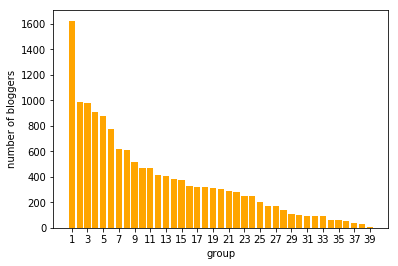

In [68]:
import matplotlib.pyplot as plt

bar_list = plt.bar(list(range(1, len(bloggers_per_group.keys())+1)), sorted(bloggers_per_group.values(), reverse=True),
                   align='center', color=['orange'])

axes = plt.gca()
plt.xticks(range(1, len(bloggers_per_group.keys())+1,2))
plt.xlabel('group')
plt.ylabel('number of bloggers')
plt.show()

In [ ]:
# load id-to-node mapping of verse embeddings
id2node_filepath = 'data/BlogCatalog-dataset/data/blogcatalog_mapping_ids_to_nodes.p'
id_2_node = {}
with open(id2node_filepath, 'rb') as id_2_node_file:
    id_2_node = pickle.load(id_2_node_file)

In [ ]:
# load node-to-id mapping of verse embeddings
node2id_filepath = 'data/BlogCatalog-dataset/data/blogcatalog_mapping_nodes_to_ids.p'
node_2_id = {}
with open(node2id_filepath, 'rb') as node_2_id_file:
    node_2_id = pickle.load(node_2_id_file)

In [ ]:
# build nodes x samples_per_node node index matrix for verse c++-implementation 
node_samples_arr = []
for i in range((len(nodes_list))):
    node = id_2_node[i]
    sampled_nodes = sim_G_sampling_reload[node]
    sampled_node_indices = []
    for n in sim_G_sampling_reload[node]:
        sampled_node_indices.append(node_2_id[n])
    node_samples_arr.extend(sampled_node_indices)

In [ ]:
# write node index sample matrix to file
node_index_samples_file_path = dataset_path + 'node_index_samples_blogcatalog_v1.smp'
with open(node_index_samples_file_path, 'wb') as node_index_samples_file:
    node_index_samples_file.write(pack('%di' % len(nodes_list)*samples_per_node, *node_samples_arr))